### <strong><span style="color:red">Part A:  Data Preparation</span></strong>


<strong>Step 1 Initial Data Processing</strong>

-load csv data into `df_full`  
-check initial shape and small sample (5 rows)  
-inspect column info  



In [177]:
# s1. data loading: code

import pandas as pd

df_full = pd.read_csv("HW3_health_headlines_10000.csv")
print("full dataset shape:", df_full.shape)

sample_df = df_full.head(5)
print(sample_df)

df_full.info()


full dataset shape: (10000, 2)
                       id                                              title
0   2008-05/aga-pop053008  Prevalence of pre-cancerous masses in the colo...
1     2008-05/e-nfo052708  New form of ECT is as effective as older types...
2  2008-05/jaaj-add050808  Anti-inflammatory drugs do not improve cogniti...
3  2008-05/jaaj-mmw052208  Many men with low testosterone levels do not r...
4  2008-05/jaaj-mot050108  Much of the increased risk of death from smoki...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10000 non-null  object
 1   title   10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


In [178]:
# Observations:
# - 2 columns present: 'id' and 'title'
# - Both columns have datatype 'object' indicating textual data

<strong>s2. Initial data cleaning</strong>

-remove duplicates based on `title`  
-check missing values in columns  
-create `cleaned_title` for standardized text  
-add `title_length` to measure word counts  
-keep columns that are important for the next step  


duplicate indices: [98, 99, 246, 251, 1733, 1759, 3568, 3589, 3729, 3811, 4858, 5084, 5993, 6024, 7612, 7613, 7664, 7733, 7872, 7947, 8842, 8877, 9012, 9054]
shape after removing duplicates: (9988, 2)
missing values per column:
id       0
title    0
dtype: int64


[nltk_data] Downloading package stopwords to /Users/DJ/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/DJ/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


top 50 words (first 10 shown):
      word  count
0    study   1426
1     risk   1364
2   cancer   1205
3  patient   1148
4      may    979
5      new    778
6  disease    717
7    heart    591
8   linked    564
9     find    557


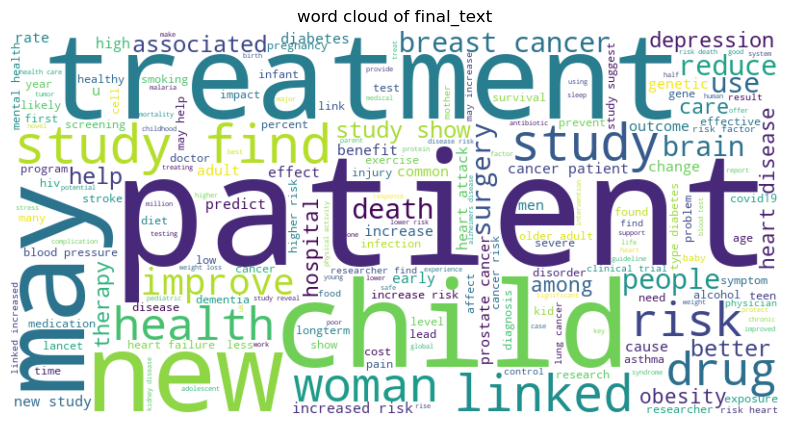

In [179]:
# part a, s2. preliminary data processing

import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import plotly.express as px

# keep a separate copy for this step
df_s2 = df_full.copy()

# locate and remove duplicates based on 'title'
dup_mask = df_s2.duplicated(subset='title', keep=False)
dup_indices = df_s2.index[dup_mask]
print("duplicate indices:", dup_indices.tolist())
df_s2.drop_duplicates(subset='title', inplace=True)

print("shape after removing duplicates:", df_s2.shape)
print("missing values per column:")
print(df_s2.isnull().sum())

# parse id for date components
df_s2[['year_month','id_code']] = df_s2['id'].str.split('/', n=1, expand=True)
df_s2['year'] = df_s2['year_month'].str[:4]
df_s2['month'] = df_s2['year_month'].str[5:7]

# define a simple text cleaner
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def clean_headline(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = text.split()
    filtered = [w for w in tokens if w not in stop_words]
    lemmed = [lemmatizer.lemmatize(w) for w in filtered]
    return " ".join(lemmed)

df_s2['final_text'] = df_s2['title'].apply(clean_headline)
df_s2['final_text_length'] = df_s2['final_text'].apply(lambda x: len(x.split()))



# top 50 words
all_words = " ".join(df_s2['final_text']).split()
counts = Counter(all_words)
top_50 = counts.most_common(50)
df_top50 = pd.DataFrame(top_50, columns=['word','count'])

print("top 50 words (first 10 shown):")
print(df_top50.head(10))

# word cloud
try:
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt

    cloud_data = " ".join(df_s2['final_text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(cloud_data)

    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title("word cloud of final_text")
    plt.show()
except ImportError:
    print("wordcloud not installed or import failed. skipping word cloud.")

# bar chart for top 50 words
fig_bar = px.bar(
    df_top50,
    x='word',
    y='count',
    title='top 50 words in final_text'
)
fig_bar.update_layout(xaxis_title='word', yaxis_title='count')
fig_bar.show()




<strong>table preview after initial processing</strong>


In [180]:
df_s2.head(6)

,id,title,year_month,id_code,year,month,final_text,final_text_length
0,2008-05/aga-pop053008,Prevalence of pre-cancerous masses in the colo...,2008-05,aga-pop053008,2008,05,prevalence precancerous mass colon patient 40 50,7
1,2008-05/e-nfo052708,New form of ECT is as effective as older types...,2008-05,e-nfo052708,2008,05,new form ect effective older type without cogn...,10
2,2008-05/jaaj-add050808,Anti-inflammatory drugs do not improve cogniti...,2008-05,jaaj-add050808,2008,05,antiinflammatory drug improve cognitive functi...,7
3,2008-05/jaaj-mmw052208,Many men with low testosterone levels do not r...,2008-05,jaaj-mmw052208,2008,05,many men low testosterone level receive treatment,7
4,2008-05/jaaj-mot050108,Much of the increased risk of death from smoki...,2008-05,jaaj-mot050108,2008,05,much increased risk death smoking reduced with...,10
5,2008-05/jotn-ait052208,Also in the May 27 JNCI,2008-05,jotn-ait052208,2008,05,also may 27 jnci,4


<strong>top words cloud</strong>

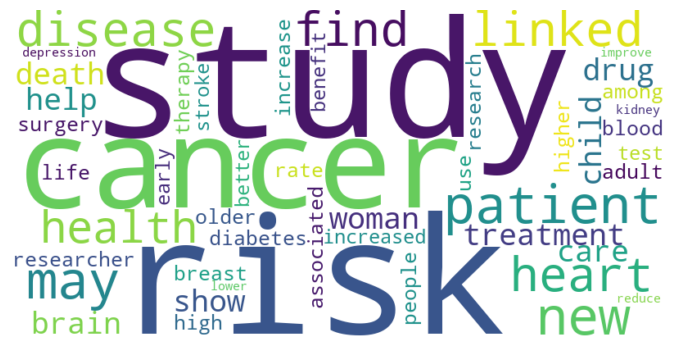

In [181]:
# install wordcloud if not already installed
!pip install wordcloud --quiet

# display first 6 rows to check current table structure
df_s2.head(6)

# optional word cloud of top 50 words
from wordcloud import WordCloud
import matplotlib.pyplot as plt

top_words_str = " ".join(df_top50['word'].values)
wc_top50 = WordCloud(width=800, height=400, background_color='white').generate(top_words_str)

plt.figure(figsize=(8.5,4.25))  # approximately 15% smaller than the original (10,5)
plt.imshow(wc_top50, interpolation='bilinear')
plt.axis('off')
plt.show()


???????<strong>b3.1 cumulative frequency preparation: breakdown message</strong>

-split `final_text` into tokens  
-compute total counts for each word  
-arrange words in descending order of frequency  
-calculate cumulative usage to facilitate threshold steps (40%, 50%, 60%, etc.)  


<h3 style="color:#4F81BD; font-family:Arial, sans-serif; font-size:110%;">Summary of Current Preprocessing Steps</h3>

<ul style="color:#333333; font-family:Arial, sans-serif;">
  <li>dataset loaded: 10,000 rows, 2 columns (<code>id</code>, <code>title</code>)</li>
  <li>duplicates removed: 9,988 rows remain (12 dropped)</li>
  <li>missing values checked: none found in columns</li>
  <li>text cleaning applied (punctuation removed, lowercase)</li>
  <li><code>title_length</code> column created (avg ~10 words; min 2, max 31)</li>
</ul>

### <strong><span style="color:red">Part B: Advanced Modifications</span></strong>

<ul>
  <li>semantic embeddings creation</li>

  <li>stopword removal</li>

  <li>lemmatization for word consistency</li>

  <li>date parsing from `id`</li>

  <li>multi-word expression detection</li>
</ul>


<strong>step 1: semantic preprocessing</strong>

<ul>
  <li><em>overview:</em></li>
  <ul>
    <li>applies domain-based word lists, phrase detection, and synonym unification</li>
    <li>removes stopwords and lemmatizes words for consistency</li>
    <li>creates a final text column for modeling</li>
  </ul>

  <li>integrate domain-based words (done)</li>
  <li>remove stopwords (done)</li>
  <li>test multiple parameters for phrase detection (done)</li>
  <li>unify synonyms (done)</li>
  <li>create final tokens and text column (done)</li>
  <li>date parsing from `id` (added below)</li>
  <li>semantic embeddings creation (will be addressed in a later step)</li>
</ul>


<strong> s1.1: semantic preprocessing</strong>


In [182]:
%%capture 
# this cell runs the transformations without showing intermediate prints or dataframe outputs

import pandas as pd
import nltk
from gensim.models.phrases import Phrases, Phraser
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

df_step1 = df_s2.copy()

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
domain_words = {'clinical','patient','study','patients','studies'}
stop_words.update(domain_words)

def clean_text_lower_stop(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = text.split()
    return [w for w in tokens if w not in stop_words]

df_step1['token_list'] = df_step1['final_text'].apply(clean_text_lower_stop)

df_step1[['year_month','id_code']] = df_step1['id'].str.split('/', n=1, expand=True)
df_step1['year'] = df_step1['year_month'].str[:4]
df_step1['month'] = df_step1['year_month'].str[5:7]

min_counts = [5, 10]
thresholds = [5, 10]
best_combo = None
best_score = 0

for mc in min_counts:
    for th in thresholds:
        phrase_model = Phrases(df_step1['token_list'], min_count=mc, threshold=th)
        pmodel = Phraser(phrase_model)
        df_step1['phrased_tokens'] = df_step1['token_list'].apply(lambda x: pmodel[x])
        multi_word_count = sum(any('_' in tok for tok in row) for row in df_step1['phrased_tokens'])
        if multi_word_count > best_score:
            best_score = multi_word_count
            best_combo = (mc, th)

final_phrase_model = Phrases(df_step1['token_list'], min_count=best_combo[0], threshold=best_combo[1])
final_pmodel = Phraser(final_phrase_model)
df_step1['phrased_tokens'] = df_step1['token_list'].apply(lambda x: final_pmodel[x])

synonym_map = {
    'tumor': 'cancer',
    'tumour': 'cancer',
    'cardiac': 'heart'
}

def unify_synonyms(tokens):
    return [synonym_map[w] if w in synonym_map else w for w in tokens]

df_step1['synonym_tokens'] = df_step1['phrased_tokens'].apply(unify_synonyms)

lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(t) for t in tokens]

df_step1['final_tokens'] = df_step1['synonym_tokens'].apply(lemmatize_tokens)
df_step1['final_text_domain'] = df_step1['final_tokens'].apply(lambda x: " ".join(x))
df_step1['domain_length'] = df_step1['final_text_domain'].apply(lambda x: len(x.split()))
df_step1['original_length'] = df_step1['title'].apply(lambda x: len(str(x).split()))


[nltk_data] Downloading package stopwords to /Users/DJ/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/DJ/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<h3 style="color:#C0504D; font-family:Arial, sans-serif; font-size:110%;">Notes</h3>

<ul style="color:#333333; font-family:Arial, sans-serif;">
  <li><code>final_text_domain</code> column created with domain-specific refinements</li>
  <li>next step: verify and compare original versus domain-specific text outputs</li>
</ul>


<strong>s1.2 domain-based enhancements check</strong>

<ul>
  <li><em>alternate title options:</em></li>
  <ul>
    <li>domain transformation validation for topic discovery</li>
    <li>transformations verification for healthcare headlines</li>
    <li>refined text confirmation for upcoming topic modeling</li>
  </ul>

  <li><em>purpose:</em> verify each item from step 1.1, ensuring correct domain-based cleaning</li>
  <li><em>scope:</em></li>
  <ul>
    <li><strong>domain-based words</strong>: confirm extra medical stopwords are applied</li>
    <li><strong>stopword removal</strong>: ensure filler words are reduced</li>
    <li><strong>phrase detection</strong>: highlight multi-word expressions in final output</li>
    <li><strong>synonym unification</strong>: check replacements (e.g. tumor → cancer)</li>
    <li><strong>final tokens & text</strong>: compare length changes & sample rows</li>
    <li><strong>date parsing</strong> from <code>id</code>: confirm <code>year</code>, <code>month</code> columns exist</li>
  </ul>
  <li><em>connection to topic mining:</em> these transformations produce consistent, domain-focused text, leading to clearer topics when using kmeans, lda, or bertopic</li>
</ul>


In [ ]:
import pandas as pd
import plotly.express as px
import re

# ensure 'original_length' in df_s2
if 'original_length' not in df_s2.columns:
    df_s2['original_length'] = df_s2['title'].apply(lambda x: len(str(x).split()))

###############################################################################
# 1) combine data
###############################################################################
df_final_check = df_s2.copy()
df_final_check['tokens_domain_removed'] = df_step1['token_list']
df_final_check['tokens_phrased']        = df_step1['phrased_tokens']
df_final_check['tokens_synonym']        = df_step1['synonym_tokens']
df_final_check['final_text']            = df_step1['final_text_domain']
df_final_check['year']                  = df_step1['year']
df_final_check['month']                 = df_step1['month']

if 'original_length' not in df_final_check.columns:
    df_final_check['original_length'] = df_final_check['title'].apply(lambda x: len(str(x).split()))

###############################################################################
# 2) define highlighting functions
###############################################################################
domain_words = {'clinical','patient','study','patients','studies'}
default_stopwords = {'the','and','of','to','in','for','on','with','that','by','an'}
synonym_map = {'tumor':'cancer','tumour':'cancer','cardiac':'heart'}

def highlight_domain_words(row):
    title_clean  = re.sub(r'[^\w\s]', '', str(row['title']).lower()).split()
    after_tokens = row['tokens_domain_removed'] or []
    removed = [w for w in title_clean if w in domain_words and w not in after_tokens]
    before_colored = []
    for w in title_clean:
        if w in removed:
            before_colored.append(f"<b style='color:green;'>{w}</b>")
        else:
            before_colored.append(w)
    return " ".join(before_colored), " ".join(after_tokens)

def highlight_stopwords(row):
    original_tokens = re.sub(r'[^\w\s]', '', str(row['title']).lower()).split()
    after_tokens = row['tokens_domain_removed'] or []
    removed = [w for w in original_tokens if w in default_stopwords and w not in after_tokens]
    before_list = []
    for w in original_tokens:
        if w in removed:
            before_list.append(f"<b style='color:red;'>{w}</b>")
        else:
            before_list.append(w)
    return " ".join(before_list), " ".join(after_tokens)

def highlight_phrases(before, after):
    underscore_pairs = [w.split('_') for w in after if '_' in w]
    after_list = []
    for w in after:
        if '_' in w:
            after_list.append(f"<b style='color:blue;'>{w}</b>")
        else:
            after_list.append(w)

    i = 0
    before_list = []
    while i < len(before):
        matched = False
        for pair in underscore_pairs:
            length_p = len(pair)
            if before[i:i+length_p] == pair:
                for p in pair:
                    before_list.append(f"<b style='color:orange;'>{p}</b>")
                i += length_p
                matched = True
                break
        if not matched:
            before_list.append(before[i])
            i += 1
    return " ".join(before_list), " ".join(after_list)

def highlight_synonyms(before, after):
    synonyms_set = set(synonym_map.values())  # e.g. {'cancer','heart'}
    min_len = min(len(before), len(after))
    bef_list, aft_list = [], []
    for i in range(min_len):
        if before[i] != after[i] and after[i] in synonyms_set:
            bef_list.append(f"<b style='color:purple;'>{before[i]}</b>")
            aft_list.append(f"<b style='color:teal;'>{after[i]}</b>")
        else:
            bef_list.append(before[i])
            aft_list.append(after[i])
    if len(before) > min_len:
        bef_list.extend(before[min_len:])
    if len(after) > min_len:
        aft_list.extend(after[min_len:])
    return " ".join(bef_list), " ".join(aft_list)

###############################################################################
# 3) select 25 rows for example table
###############################################################################
domain_idx   = df_final_check[df_final_check['title'].str.contains(r'patient|study', case=False, na=False)].index[:10]
phrase_idx   = df_final_check[df_final_check['final_text'].str.contains('_', na=False)].index[:10]
synonym_idx  = df_final_check[df_final_check['final_text'].str.contains(r'\bcancer\b|\bheart\b', na=False)].index[:10]

combined_idx = list(domain_idx) + list(phrase_idx) + list(synonym_idx)
combined_idx = list(dict.fromkeys(combined_idx))  # remove duplicates, preserve order

if len(combined_idx) < 25:
    extra_needed = 25 - len(combined_idx)
    all_rows = df_final_check.index.difference(combined_idx)
    combined_idx += list(all_rows[:extra_needed])

df_demo_25 = df_final_check.loc[combined_idx].copy().head(25)
df_demo_25['example_index'] = range(1, len(df_demo_25)+1)

# highlight columns
df_demo_25[['domain_before','domain_after']] = df_demo_25.apply(
    lambda row: highlight_domain_words(row), axis=1, result_type='expand'
)
df_demo_25[['stop_before','stop_after']] = df_demo_25.apply(
    lambda row: highlight_stopwords(row), axis=1, result_type='expand'
)
df_demo_25[['phrases_before','phrases_after']] = df_demo_25.apply(
    lambda row: highlight_phrases(
        row['tokens_domain_removed'] or [],
        row['tokens_phrased'] or []
    ),
    axis=1, result_type='expand'
)
df_demo_25[['syn_bef','syn_aft']] = df_demo_25.apply(
    lambda row: highlight_synonyms(
        row['tokens_phrased'] or [],
        row['tokens_synonym'] or []
    ),
    axis=1, result_type='expand'
)

table_cols = [
    'example_index',
    'id',
    'title',
    'domain_before','domain_after',
    'stop_before','stop_after',
    'phrases_before','phrases_after',
    'syn_bef','syn_aft',
    'final_text',
    'year','month'
]

print("25 selected rows demonstrating each transformation (with example_index):\n")
display(
    df_demo_25[table_cols].style.hide(axis='index').set_properties(**{
        'text-align': 'left',
        'white-space': 'pre-wrap'
    })
)

###############################################################################
# 4) single histogram of original vs final lengths
###############################################################################
df_hist = pd.DataFrame({
    'text_type': (['original']*len(df_s2)) + (['final']*len(df_s2)),
    'length': list(df_s2['original_length']) + list(df_final_check['final_text'].apply(lambda x: len(str(x).split())))
})

fig = px.histogram(
    df_hist,
    x='length',
    color='text_type',
    barmode='overlay',
    title='word count distribution: original vs domain-transformed'
)
fig.update_layout(
    xaxis_title='word count',
    yaxis_title='frequency',
    legend_title_text='text type'
)
fig.show()

###############################################################################
# 5) final report: entire dataset counts + references to example_index
###############################################################################
# 5a) compute full-dataset counts (for the 'total_count' column)
domain_removed_count_all = 0
stop_removed_count_all   = 0
phrase_count_all         = 0
syn_count_all            = 0

for idx, row in df_final_check.iterrows():
    original_tokens = re.sub(r'[^\w\s]', '', str(row['title']).lower()).split()
    after_dom = row['tokens_domain_removed'] or []
    # domain
    removed_d = [w for w in original_tokens if w in domain_words and w not in after_dom]
    domain_removed_count_all += len(removed_d)
    # stopwords
    removed_sw = [w for w in original_tokens if w in default_stopwords and w not in after_dom]
    stop_removed_count_all += len(removed_sw)
    # phrase detection
    ph_tokens = row['tokens_phrased'] or []
    phrase_count_all += sum('_' in t for t in ph_tokens)
    # synonyms
    syn_tokens = row['tokens_synonym'] or []
    synonyms_set = set(synonym_map.values())
    syn_count_all += sum(1 for w in syn_tokens if w in synonyms_set)

# date parse count
date_parse_count_all = df_final_check[
    df_final_check['year'].notnull() & df_final_check['month'].notnull()
].shape[0]

# 5b) also compute how many distinct titles are involved for each remedy
domain_title_involved = set()
stop_title_involved   = set()
phrase_title_involved = set()
synonym_title_involved= set()
date_parse_titles     = set()

for idx, row in df_final_check.iterrows():
    original_tokens = re.sub(r'[^\w\s]', '', str(row['title']).lower()).split()
    after_dom = row['tokens_domain_removed'] or []

    domain_removed_temp = [w for w in original_tokens if w in domain_words and w not in after_dom]
    if domain_removed_temp:
        domain_title_involved.add(idx)

    stop_removed_temp = [w for w in original_tokens if w in default_stopwords and w not in after_dom]
    if stop_removed_temp:
        stop_title_involved.add(idx)

    tokens_ph = row['tokens_phrased'] or []
    underscore_count = sum('_' in t for t in tokens_ph)
    if underscore_count > 0:
        phrase_title_involved.add(idx)

    tokens_syn = row['tokens_synonym'] or []
    replaced_syn = sum(1 for w in tokens_syn if w in set(synonym_map.values()))
    if replaced_syn > 0:
        synonym_title_involved.add(idx)

    if pd.notnull(row['year']) and pd.notnull(row['month']):
        date_parse_titles.add(idx)

domain_titles_count = len(domain_title_involved)
stop_titles_count   = len(stop_title_involved)
phrase_titles_count = len(phrase_title_involved)
syn_titles_count    = len(synonym_title_involved)
date_titles_count   = len(date_parse_titles)

# 5c) gather example_indices from the 25-row subset
domain_examples_idx = []
stopwords_examples_idx = []
phrase_examples_idx = []
synonym_examples_idx = []
date_examples_idx = []

for i, row in df_demo_25.iterrows():
    original_tokens = re.sub(r'[^\w\s]', '', str(row['title']).lower()).split()
    after_dom = row['tokens_domain_removed'] or []
    # domain
    removed_dom = [w for w in original_tokens if w in domain_words and w not in after_dom]
    if removed_dom:
        domain_examples_idx.append(row['example_index'])
    # stopwords
    removed_sw = [w for w in original_tokens if w in default_stopwords and w not in after_dom]
    if removed_sw:
        stopwords_examples_idx.append(row['example_index'])
    # phrase
    tokens_ph = row['tokens_phrased'] or []
    underscores = sum('_' in t for t in tokens_ph)
    if underscores > 0:
        phrase_examples_idx.append(row['example_index'])
    # synonyms
    replaced_syn = sum(1 for w in (row['tokens_synonym'] or []) if w in set(synonym_map.values()))
    if replaced_syn > 0:
        synonym_examples_idx.append(row['example_index'])
    # date parse
    if pd.notnull(row['year']) and pd.notnull(row['month']):
        date_examples_idx.append(row['example_index'])

###############################################################################
# 5d) build final df_report (index 1..5, no remedy_id column)
###############################################################################
repairs_list = [
    "domain_words_removed",
    "stopwords_removed",
    "phrase_detections",
    "synonym_replacements",
    "rows_with_date_parse"
]
descriptions = [
    "cuts specific medical filler, focusing on relevant domain terms.",
    "removes general filler words, clarifying text for clustering.",
    "merges multi-word entities (heart_disease), aiding topic coherence.",
    "standardizes references (tumor->cancer), preventing fragmented topics.",
    "allows time-based trend analysis in kmeans, lda, or bertopic."
]
full_dataset_counts = [
    domain_removed_count_all,
    stop_removed_count_all,
    phrase_count_all,
    syn_count_all,
    date_parse_count_all
]
titles_involved = [
    domain_titles_count,
    stop_titles_count,
    phrase_titles_count,
    syn_titles_count,
    date_titles_count
]
example_indices_all = [
    domain_examples_idx,
    stopwords_examples_idx,
    phrase_examples_idx,
    synonym_examples_idx,
    date_examples_idx
]

df_report = pd.DataFrame({
    'repairs': repairs_list,
    'total_count': full_dataset_counts,
    'total_title_involved': titles_involved,
    'example_indices': example_indices_all,
    'description': descriptions
})

# set df_report index to [1..5], removing any 'remedy_id' entirely
df_report.index = [1,2,3,4,5]

display(df_report.style.set_properties(**{'text-align': 'left'}))

25 selected rows demonstrating each transformation (with example_index):



example_index,id,title,domain_before,domain_after,stop_before,stop_after,phrases_before,phrases_after,syn_bef,syn_aft,final_text,year,month
1,2008-05/aga-pop053008,Prevalence of pre-cancerous masses in the colon same in patients in their 40s and 50s,prevalence of precancerous masses in the colon same in patients in their 40s and 50s,prevalence precancerous mass colon 40 50,prevalence of precancerous masses in the colon same in patients in their 40s and 50s,prevalence precancerous mass colon 40 50,prevalence precancerous mass colon 40 50,prevalence precancerous mass colon 40 50,prevalence precancerous mass colon 40 50,prevalence precancerous mass colon 40 50,prevalence precancerous mass colon 40 50,2008,05
2,2008-06/aaop-ruh061008,Researchers uncover higher prevalence of periodontal disease in rheumatoid arthritis patients,researchers uncover higher prevalence of periodontal disease in rheumatoid arthritis patients,researcher uncover higher prevalence periodontal disease rheumatoid arthritis,researchers uncover higher prevalence of periodontal disease in rheumatoid arthritis patients,researcher uncover higher prevalence periodontal disease rheumatoid arthritis,researcher uncover higher prevalence periodontal disease rheumatoid arthritis,researcher_uncover higher prevalence periodontal disease rheumatoid_arthritis,researcher_uncover higher prevalence periodontal disease rheumatoid_arthritis,researcher_uncover higher prevalence periodontal disease rheumatoid_arthritis,researcher_uncover higher prevalence periodontal disease rheumatoid_arthritis,2008,06
3,2008-06/asop-csp062408,"Cosmetic surgery procedures to exceed 55 million in 2015, ASPS study predicts",cosmetic surgery procedures to exceed 55 million in 2015 asps study predicts,cosmetic surgery procedure exceed 55 million 2015 asp predicts,cosmetic surgery procedures to exceed 55 million in 2015 asps study predicts,cosmetic surgery procedure exceed 55 million 2015 asp predicts,cosmetic surgery procedure exceed 55 million 2015 asp predicts,cosmetic surgery procedure exceed 55 million 2015 asp predicts,cosmetic surgery procedure exceed 55 million 2015 asp predicts,cosmetic surgery procedure exceed 55 million 2015 asp predicts,cosmetic surgery procedure exceed 55 million 2015 asp predicts,2008,06
4,2008-06/w-snc060908,Specialist nurses can play a key role in supporting patients having radiotherapy,specialist nurses can play a key role in supporting patients having radiotherapy,specialist nurse play key role supporting radiotherapy,specialist nurses can play a key role in supporting patients having radiotherapy,specialist nurse play key role supporting radiotherapy,specialist nurse play key role supporting radiotherapy,specialist nurse play_key role supporting radiotherapy,specialist nurse play_key role supporting radiotherapy,specialist nurse play_key role supporting radiotherapy,specialist nurse play_key role supporting radiotherapy,2008,06
5,2008-06/w-soa060208,Study of anti-CD20 therapy effective B cell depletion,study of anticd20 therapy effective b cell depletion,anticd20 therapy effective b cell depletion,study of anticd20 therapy effective b cell depletion,anticd20 therapy effective b cell depletion,anticd20 therapy effective b cell depletion,anticd20 therapy effective b cell depletion,anticd20 therapy effective b cell depletion,anticd20 therapy effective b cell depletion,anticd20 therapy effective b cell depletion,2008,06
6,2008-07/eu-pri072108,Promising results in deep brain stimulation for patients with treatment-resistant depression,promising results in deep brain stimulation for patients with treatmentresistant depression,promising result deep brain stimulation treatmentresistant depression,promising results in deep brain stimulation for patients with treatmentresistant depression,promising result deep brain stimulation treatmentresistant depression,promising result deep brain stimulation treatmentresistant depression,promising result deep_brain stimulation treatmentr


##final report of repairs (entire dataset counts + references to example_index)##



,repairs,total_count,total_title_involved,example_indices,description
1,domain_words_removed,2692,2512,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 24, 25]","cuts specific medical filler, focusing on relevant domain terms."
2,stopwords_removed,15949,8577,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22, 23, 24, 25]","removes general filler words, clarifying text for clustering."
3,phrase_detections,8023,5673,"[2, 4, 6, 8, 10, 11, 12, 13, 14, 15, 16, 17, 21, 23]","merges multi-word entities (heart_disease), aiding topic coherence."
4,synonym_replacements,742,712,"[14, 18, 19, 20, 21, 22, 23, 24, 25]","standardizes references (tumor->cancer), preventing fragmented topics."
5,rows_with_date_parse,9988,9988,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]","allows time-based trend analysis in kmeans, lda, or bertopic."


<strong>column descriptions</strong>

-id unique identifier from original data

-title raw headline text from the dataset

-final_text cleaned version of `title` (punctuation removed, stopwords removed, lemmatized)

-year extracted year from `id`

-month extracted month from `id`

-parsed_date datetime with day '01' appended for valid format

-final_text_length word count from `final_text` (indicates text size)



<strong>update so far</strong>

-check dataset shape:10,000 rows,2 columns(id,title)

-remove duplicates:9,988 rows remain(12 removed)

-check missing values:none in id,title,cleaned_title,title_length

-text cleaning:cleaned_title created(punctuation removed,lowercase applied)

-title length:title_length added(avg:10 words,min:2,max:31)

<strong>s4. kmeans clustering: breakdown message</strong>

-build numerical vectors from `final_text`  
-check different values of k (elbow or silhouette)  
-fit kmeans model with chosen k  
-assign cluster labels and explore dominant terms  


<strong>s4.1 vectorization: breakdown message</strong>

-transform `final_text` into numeric form  
-use tf-idf to capture word importance  
-prepare matrix for kmeans  


In [184]:
# s4.1 vectorization: code

from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# convert texts to numeric tf-idf format, removing common English words
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X = tfidf_vectorizer.fit_transform(df_full['final_text'])

# convert sparse matrix to dataframe for clearer viewing
tfidf_df = pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# display first 10 rows with diverse column selections for a better overview
print(tfidf_df.iloc[:10, [0, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000]])

# explicitly show shape of resulting dataframe
print("tfidf shape:", tfidf_df.shape)


KeyError: 'final_text'

<strong>s4.2 cluster selection: breakdown message</strong>

-try multiple cluster counts  
-calculate silhouette scores  
-select the best k  


In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd

# convert texts to numeric tf-idf format, removing common English words
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X = tfidf_vectorizer.fit_transform(df_full['final_text'])

# prepare list of possible cluster numbers to test
possible_k = [5, 7, 10]

# variables to store best number of clusters and its silhouette score
best_k = None
best_score = -1

# test each k, fit k-means, calculate silhouette scores to find optimal number of clusters
for k in possible_k:
    model_temp = KMeans(n_clusters=k, random_state=42)
    model_temp.fit(X)
    labels_temp = model_temp.labels_
    score_temp = silhouette_score(X, labels_temp)
    
    # print intermediate silhouette scores clearly
    print("For k =", k, ", silhouette score:", round(score_temp, 3))

    # check and store best silhouette score and corresponding k
    if score_temp > best_score:
        best_score = score_temp
        best_k = k

# display best k based on silhouette scores
print("\nBest k selected:", best_k, "(silhouette score:", round(best_score, 3), ")")


For k = 5 , silhouette score: 0.004
For k = 7 , silhouette score: 0.005
For k = 10 , silhouette score: 0.007

Best k selected: 10 (silhouette score: 0.007 )


<strong>silhouette score: explanation</strong>

-measures cluster separation and cohesion

-ranges from -1 to +1

-score close to (1) indicates clear, distinct clusters

-score close to (0) indicates overlapping or unclear clusters

-negative scores indicate incorrect cluster assignments

-used to identify best cluster count(k) by selecting highest score

<span style="color:darkblue;"><strong>s4.3 embedding-based approach: breakdown message</strong></span>

-use semantic embeddings for deeper representation  
-replace or combine tf-idf vectors with embeddings  
-refit clustering with new vectors  
-check if silhouette scores or cluster separations improve  
-typical low scores in text mining, but embeddings may reduce overlap  



<strong> reasoning behind embedding-based approach</strong>

-previous silhouette scores (0.004, 0.005, 0.007) suggest minimal cluster separation  

-very low silhouette scores are common in text mining

-text data inherently diverse and overlapping

-difficult for clusters to form clearly-separated groups due to semantic ambiguity

-embeddings capture more context than tf-idf alone  


In [82]:
# s4.3 embedding-based approach

import gensim.downloader as api
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# load a pre-trained embedding model (example uses glove)
embedding_model = api.load('glove-wiki-gigaword-50')

# convert each cleaned title to an average embedding
def text_to_embedding(text):
    tokens = text.split()
    vectors = [embedding_model[word] for word in tokens if word in embedding_model]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(50)

# apply embedding conversion to all cleaned titles
embeddings_list = df_full['final_text'].apply(text_to_embedding)
embeddings_matrix = np.vstack(embeddings_list.values)

# test different k values
k_values = [5, 8, 10]
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(embeddings_matrix)
    labels = km.labels_
    sil_score = silhouette_score(embeddings_matrix, labels)
    print("k =", k, "silhouette =", round(sil_score, 4))

# personal notes
# - embeddings add semantic detail
# - silhouette scores might still be low, but can be compared with tf-idf results
# - next step: refine preprocessing or explore advanced embedding methods


k = 5 silhouette = 0.0392
k = 8 silhouette = 0.0345
k = 10 silhouette = 0.0353


<strong>s4.4 advanced embeddings and phrase detection: breakdown message</strong>

-based on s4.3 results (silhouette scores in the range of 0.03 to 0.04)  
-try domain-tuned embeddings to capture medical context  
-detect multi-word expressions like “heart disease” or “cancer treatment”  
-improve cluster coherence through specialized text representations  


In [ ]:
# s4.4 advanced embeddings and phrase detection: code

# example approach using gensim's phrases for multi-word detection
# note: domain embeddings like 'BioWordVec' or 'ClinicalBERT' may require additional setup

import gensim
from gensim.models.phrases import Phrases, Phraser
import nltk

# ensure tokenization or lemmatization is consistent with previous steps
# convert final_text into a list of token lists
df_full['token_list'] = df_full['final_text'].apply(lambda x: x.split())

# build phrase model to detect common multi-word expressions
phrases = Phrases(df_full['token_list'], min_count=5, threshold=10)
phrase_model = Phraser(phrases)

# transform token_list to include phrases
df_full['phrased_tokens'] = df_full['token_list'].apply(lambda x: phrase_model[x])

# optional: load domain embedding (example shows glove-wiki-gigaword-50 as placeholder)
import gensim.downloader as api
embedding_model = api.load("glove-wiki-gigaword-50")

def text_to_embedding(token_list):
    # combines word vectors into a single average embedding
    vectors = [embedding_model[word] for word in token_list if word in embedding_model]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(50)

# create an embedding matrix for the phrased tokens
embed_list = df_full['phrased_tokens'].apply(text_to_embedding)
embed_matrix = np.vstack(embed_list.values)

# run kmeans again to see if new approach helps
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k_candidates = [5, 8, 10]
for k in k_candidates:
    kmeans_model = KMeans(n_clusters=k, random_state=42)
    kmeans_model.fit(embed_matrix)
    labels = kmeans_model.labels_
    score = silhouette_score(embed_matrix, labels)
    print("k =", k, "silhouette =", round(score, 4))

# personal notes
# - multi-word detection preserves important phrases (like heart_disease)
# - domain embeddings might boost semantic understanding
# - next step is to compare silhouette scores and inspect cluster quality


k = 5 silhouette = 0.042
k = 8 silhouette = 0.0388
k = 10 silhouette = 0.0353


<strong>s5. lda topic modeling: overview</strong>

-discover hidden themes based on word distributions  
-treat each `cleaned_title` as a mixture of these hidden topics  
-transform text into numeric form using tokenization and dictionaries  
-iteratively adjust topic-word assignments to reflect underlying patterns  
-examine top words in each topic to assign labels or detect unclear groups  


In [ ]:
# umap + kmeans

import umap.umap_ as umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# assume we have an embedding matrix from tf-idf or glove
X_tfidf = vec_syn.fit_transform(df_full['final_text'])

# reduce dimensions to (2) or (5, etc.)
umap_reducer = umap.UMAP(n_neighbors=15, n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X_tfidf)

# cluster umap output
for k in [5,8,10]:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_umap)
    labels = km.labels_
    score = silhouette_score(X_umap, labels)
    print("k =", k, "silhouette =", round(score, 4))


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



k = 5 silhouette = 0.3277
k = 8 silhouette = 0.327
k = 10 silhouette = 0.3317
